In [1]:
import tensorflow as tf
import tensorflow_probability as tfp
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import h5py
import keras
import os
import tensorboard
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, GlobalMaxPooling2D, Dropout, Input, Concatenate
from tensorflow.keras.regularizers import L2
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler
from tensorboard.plugins.hparams import api as hp

from photoz_utils import *
from DataMakerPlus import *

2023-08-26 15:47:48.375938: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-26 15:47:48.917154: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-08-26 15:47:48.917198: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2023-08-26 15:47:48.917202: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nv

In [2]:
GB_LIMIT = 10

In [3]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_virtual_device_configuration(
            gpus[0],
            [tf.config.experimental.VirtualDeviceConfiguration(GB_LIMIT*1000)])
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [4]:
IMAGE_SHAPE = (5, 127, 127)
NUM_DENSE_UNITS = 200
BATCH_SIZE = 256
NUM_EPOCHS = 100
LEARNING_RATE = 0.0001
Z_MAX = 4
hparams = {
    'num_dense_units': NUM_DENSE_UNITS,
    'batch_size': BATCH_SIZE,
    'num_epochs': NUM_EPOCHS,
    'learning_rate': LEARNING_RATE,
    'z_max': Z_MAX
}

In [5]:
TRAIN_PATH = f'/data/HSC/HSC_v6/step2A/127x127/5x127x127_training.hdf5'
VAL_PATH = f'/data/HSC/HSC_v6/step2A/127x127/5x127x127_validation.hdf5'
TEST_PATH = f'/data/HSC/HSC_v6/step2A/127x127/5x127x127_testing.hdf5'

In [6]:
# param_names = []
# for i in ['g', 'r', 'i', 'z', 'y']:
#     for j in ['cmodel_mag', 'isophotal_area', 'half_light_radius', 'major_axis', 'minor_axis', 'ellipticity', 'sersic_index', 'peak_surface_brightness']:
#         param_names.append(i + '_' + j)
# v17

param_names = []
for i in ['g', 'r', 'i', 'z', 'y']:
    for j in ['cmodel_mag']:
        param_names.append(i + '_' + j)
        # v19

In [7]:
param_names

['g_cmodel_mag',
 'r_cmodel_mag',
 'i_cmodel_mag',
 'z_cmodel_mag',
 'y_cmodel_mag']

In [8]:
gen_args = {
    'image_key': 'image',
    'numerical_keys': param_names,
    'y_key': 'specz_redshift',
    'scaler': True,
    'labels_encoding': False,
    'batch_size': hparams['batch_size'],
    'shuffle': False}

In [9]:
train_gen = HDF5DataGenerator(TRAIN_PATH, mode='train', **gen_args)
val_gen = HDF5DataGenerator(VAL_PATH, mode='train', **gen_args)
test_gen = HDF5DataGenerator(TEST_PATH, mode='test', **gen_args)

In [10]:
import keras.backend as K

def calculate_loss(z_photo, z_spec):
    """
    HSC METRIC. Returns an array. Loss is accuracy metric defined by HSC, meant
    to capture the effects of bias, scatter, and outlier all in one. This has
    uses for both point and density estimation.
    z_photo: array
        Photometric or predicted redshifts.
    z_spec: array
        Spectroscopic or actual redshifts.
    """
    dz = delz(z_photo, z_spec)
    gamma = 0.15
    denominator = 1.0 + K.square(dz/gamma)
    loss = 1 - 1.0 / denominator
    return loss

In [11]:
input_cnn = Input(shape=(5,127,127))
input_nn = Input(shape=(len(param_names),)) # don't forget to change this

# CNN
conv1 = Conv2D(32, kernel_size=(3, 3), activation='tanh', padding='same', data_format='channels_first')(input_cnn)
pool1 = MaxPooling2D(pool_size = (2,2), data_format='channels_first')(conv1)
conv2 = Conv2D(64, kernel_size=(3, 3), activation='tanh', padding='same', data_format='channels_first')(pool1)
pool2 = MaxPooling2D(pool_size = (2,2), data_format='channels_first')(conv2)
conv3 = Conv2D(128, kernel_size=(3, 3), activation='tanh', padding='same', data_format='channels_first')(pool2)
pool3 = MaxPooling2D(pool_size = (2,2), data_format='channels_first')(conv3)
conv4 = Conv2D(256, kernel_size=(3, 3), activation='tanh', padding='same', data_format='channels_first')(pool3)
pool4 = MaxPooling2D(pool_size = (2,2), data_format='channels_first')(conv4)
conv5 = Conv2D(256, kernel_size=(3, 3), activation='tanh', padding='same', data_format='channels_first')(pool4)
pool5 = MaxPooling2D(pool_size = (2,2), data_format='channels_first')(conv5)
conv6 = Conv2D(512, kernel_size=(3, 3),activation='relu', padding='same', data_format='channels_first')(pool5)
conv7 = Conv2D(512, kernel_size=(3, 3),activation='relu', padding='same', data_format='channels_first')(conv6)
flatten = GlobalMaxPooling2D(data_format='channels_first')(conv7)
dense1 = Dense(512, activation='tanh')(flatten)
dense2 = Dense(128, activation='tanh')(dense1)
dense3 = Dense(32, activation='tanh')(dense2)

# NN
hidden1 = Dense(hparams['num_dense_units'], activation="relu")(input_nn)
hidden2 = Dense(hparams['num_dense_units'], activation="relu")(hidden1)
hidden3 = Dense(hparams['num_dense_units'], activation="relu")(hidden2)
hidden4 = Dense(hparams['num_dense_units'], activation="relu")(hidden3)
hidden5 = Dense(hparams['num_dense_units'], activation="relu")(hidden4)
hidden6 = Dense(hparams['num_dense_units'], activation="relu")(hidden5)

# Concat & Output
concat = Concatenate()([dense3, hidden6])
output = Dense(1)(concat)
model = Model(inputs=[input_cnn, input_nn], outputs=[output])

In [12]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 5, 127, 127  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 32, 127, 127  1472        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 32, 63, 63)   0           ['conv2d[0][0]']                 
                                                                                              

In [13]:
model.compile(optimizer=Adam(learning_rate=hparams['learning_rate']), loss=calculate_loss, metrics='mse')

In [14]:
model_name = 'HSC_v6_NN_neurips_combined_with_5pool_v25'

checkpoint_filepath = f'/data2/models/{model_name}/checkpoints/cp.ckpt'
checkpoint_dir = os.path.dirname(checkpoint_filepath)
log_dir = os.path.join('/data2/logs/', model_name)

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='loss',
    mode='min',
    save_freq='epoch',
    save_best_only=True,
    verbose=True)

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

hparam_callback = hp.KerasCallback(log_dir, hparams)

In [15]:
model.fit(train_gen, batch_size=hparams['batch_size'], epochs=hparams['num_epochs'], shuffle=True, verbose=1, validation_data=val_gen, callbacks=[tensorboard_callback, model_checkpoint_callback, hparam_callback])

Epoch 1/100
784/784 [==============================] - ETA: 0s - loss: 0.2624 - mse: 0.2370
Epoch 1: loss improved from inf to 0.26243, saving model to /data2/models/HSC_v6_NN_neurips_combined_with_5pool_v25/checkpoints/cp.ckpt
784/784 [==============================] - 588s 742ms/step - loss: 0.2624 - mse: 0.2370 - val_loss: 0.2538 - val_mse: 0.1474
Epoch 2/100
784/784 [==============================] - ETA: 0s - loss: 0.1858 - mse: 0.1096
Epoch 2: loss improved from 0.26243 to 0.18581, saving model to /data2/models/HSC_v6_NN_neurips_combined_with_5pool_v25/checkpoints/cp.ckpt
784/784 [==============================] - 610s 779ms/step - loss: 0.1858 - mse: 0.1096 - val_loss: 0.1736 - val_mse: 0.0968
Epoch 3/100
784/784 [==============================] - ETA: 0s - loss: 0.1610 - mse: 0.1010
Epoch 3: loss improved from 0.18581 to 0.16099, saving model to /data2/models/HSC_v6_NN_neurips_combined_with_5pool_v25/checkpoints/cp.ckpt
784/784 [==============================] - 639s 815ms/step

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)




Epoch 33: loss improved from 0.05648 to 0.05431, saving model to /data2/models/HSC_v6_NN_neurips_combined_with_5pool_v25/checkpoints/cp.ckpt
784/784 [==============================] - 689s 879ms/step - loss: 0.0543 - mse: 0.0664 - val_loss: 0.0659 - val_mse: 0.0699
Epoch 34/100
784/784 [==============================] - ETA: 0s - loss: 0.0598 - mse: 0.0667
Epoch 34: loss did not improve from 0.05431
784/784 [==============================] - 682s 870ms/step - loss: 0.0598 - mse: 0.0667 - val_loss: 0.0654 - val_mse: 0.0702
Epoch 35/100
784/784 [==============================] - ETA: 0s - loss: 0.0517 - mse: 0.0645
Epoch 35: loss improved from 0.05431 to 0.05169, saving model to /data2/models/HSC_v6_NN_neurips_combined_with_5pool_v25/checkpoints/cp.ckpt
784/784 [==============================] - 663s 846ms/step - loss: 0.0517 - mse: 0.0645 - val_loss: 0.0620 - val_mse: 0.0656
Epoch 36/100
784/784 [==============================] - ETA: 0s - loss: 0.0501 - mse: 0.0627
Epoch 36: loss impr

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



784/784 [==============================] - ETA: 0s - loss: 0.0352 - mse: 0.0416
Epoch 61: loss improved from 0.03684 to 0.03519, saving model to /data2/models/HSC_v6_NN_neurips_combined_with_5pool_v25/checkpoints/cp.ckpt
784/784 [==============================] - 614s 784ms/step - loss: 0.0352 - mse: 0.0416 - val_loss: 0.0601 - val_mse: 0.0569
Epoch 62/100
784/784 [==============================] - ETA: 0s - loss: 0.0340 - mse: 0.0416
Epoch 62: loss improved from 0.03519 to 0.03403, saving model to /data2/models/HSC_v6_NN_neurips_combined_with_5pool_v25/checkpoints/cp.ckpt
784/784 [==============================] - 641s 817ms/step - loss: 0.0340 - mse: 0.0416 - val_loss: 0.0583 - val_mse: 0.0537
Epoch 63/100
784/784 [==============================] - ETA: 0s - loss: 0.0382 - mse: 0.0440
Epoch 63: loss did not improve from 0.03403
784/784 [==============================] - 638s 813ms/step - loss: 0.0382 - mse: 0.0440 - val_loss: 0.0597 - val_mse: 0.0583
Epoch 64/100
687/784 [===========

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



784/784 [==============================] - ETA: 0s - loss: 0.0252 - mse: 0.0320
Epoch 83: loss improved from 0.02643 to 0.02523, saving model to /data2/models/HSC_v6_NN_neurips_combined_with_5pool_v25/checkpoints/cp.ckpt
784/784 [==============================] - 671s 855ms/step - loss: 0.0252 - mse: 0.0320 - val_loss: 0.0578 - val_mse: 0.0529
Epoch 84/100
784/784 [==============================] - ETA: 0s - loss: 0.0257 - mse: 0.0329
Epoch 84: loss did not improve from 0.02523
784/784 [==============================] - 721s 919ms/step - loss: 0.0257 - mse: 0.0329 - val_loss: 0.0585 - val_mse: 0.0552
Epoch 85/100
784/784 [==============================] - ETA: 0s - loss: 0.0263 - mse: 0.0333
Epoch 85: loss did not improve from 0.02523
784/784 [==============================] - 664s 847ms/step - loss: 0.0263 - mse: 0.0333 - val_loss: 0.0593 - val_mse: 0.0549
Epoch 86/100
784/784 [==============================] - ETA: 0s - loss: 0.0281 - mse: 0.0336
Epoch 86: loss did not improve from 0

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [16]:
# might take too much memory, use PCA on morphology

In [17]:
model.load_weights(checkpoint_filepath)

In [18]:
pred = model.predict(test_gen)

168/168 [==============================] - 118s 696ms/step


In [19]:
with h5py.File(TEST_PATH, 'r') as file:
    y_test = np.asarray(file['specz_redshift'][:])
    oid_test = np.asarray(file['object_id'][:])

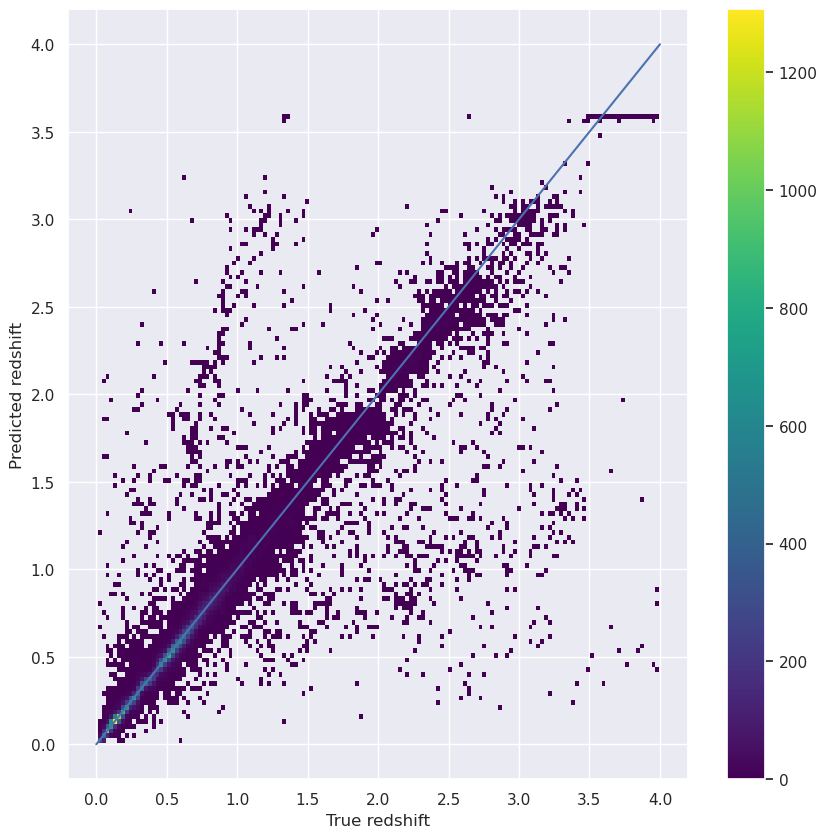

In [20]:
plot_predictions(np.ravel(pred), y_test)

In [21]:
metrics = get_point_metrics(pd.Series(np.ravel(pred)), pd.Series(y_test), binned=False)

In [22]:
metrics

,zspec_bin,count,L,bias_bw,bias_conv,scatter_bw,scatter_conv,outlier_bw,outlier_conv,mse
0,"(0.0, 4.0]",42960,0.055949,-0.002591,-0.00255,0.019724,0.016768,0.14183,0.035847,0.049169


In [23]:
df = pd.DataFrame(pred, columns=['photoz'])
df['specz'] = pd.Series(y_test)
df['object_id'] = pd.Series(oid_test)
os.makedirs(f'/data2/predictions/{model_name}', exist_ok=True)
df.to_csv(f'/data2/predictions/{model_name}/testing_predictions.csv', index=False)
metrics.to_csv(f'/data2/predictions/{model_name}/testing_metrics.csv', index=False)